In [2]:
import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(f'Dataset: {dataset}:')
print('------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora():
------------------
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [4]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
device

device(type='cuda')

In [6]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs


In [7]:
train_losses = []
val_accuracies = []

for epoch in range(25):
    loss = train()
    _, val_acc, _ = test()
    train_losses.append(loss)
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 0, Loss: 1.9428, Val Acc: 0.3200
Epoch 1, Loss: 1.8139, Val Acc: 0.4420
Epoch 2, Loss: 1.6709, Val Acc: 0.5440
Epoch 3, Loss: 1.5253, Val Acc: 0.6400
Epoch 4, Loss: 1.3574, Val Acc: 0.6820
Epoch 5, Loss: 1.2325, Val Acc: 0.7080
Epoch 6, Loss: 1.1100, Val Acc: 0.7300
Epoch 7, Loss: 0.9968, Val Acc: 0.7480
Epoch 8, Loss: 0.8875, Val Acc: 0.7580
Epoch 9, Loss: 0.7808, Val Acc: 0.7600
Epoch 10, Loss: 0.6743, Val Acc: 0.7620
Epoch 11, Loss: 0.6193, Val Acc: 0.7640
Epoch 12, Loss: 0.5237, Val Acc: 0.7720
Epoch 13, Loss: 0.4601, Val Acc: 0.7760
Epoch 14, Loss: 0.3635, Val Acc: 0.7780
Epoch 15, Loss: 0.3391, Val Acc: 0.7760
Epoch 16, Loss: 0.3528, Val Acc: 0.7780
Epoch 17, Loss: 0.3096, Val Acc: 0.7800
Epoch 18, Loss: 0.2640, Val Acc: 0.7800
Epoch 19, Loss: 0.2024, Val Acc: 0.7780
Epoch 20, Loss: 0.2492, Val Acc: 0.7740
Epoch 21, Loss: 0.1919, Val Acc: 0.7700
Epoch 22, Loss: 0.1613, Val Acc: 0.7640
Epoch 23, Loss: 0.1584, Val Acc: 0.7600
Epoch 24, Loss: 0.1359, Val Acc: 0.7580


In [8]:
print(f'\nFinal Test Accuracy: {test()[2]:.4f}')


Final Test Accuracy: 0.7980


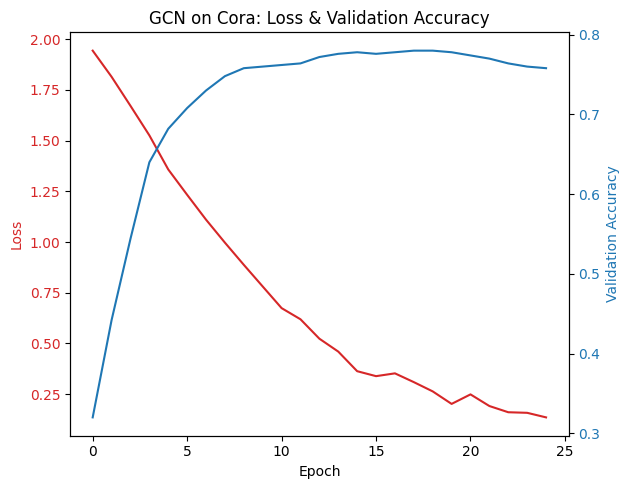

In [9]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(train_losses, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy', color='tab:blue')
ax2.plot(val_accuracies, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title('GCN on Cora: Loss & Validation Accuracy')
plt.show()


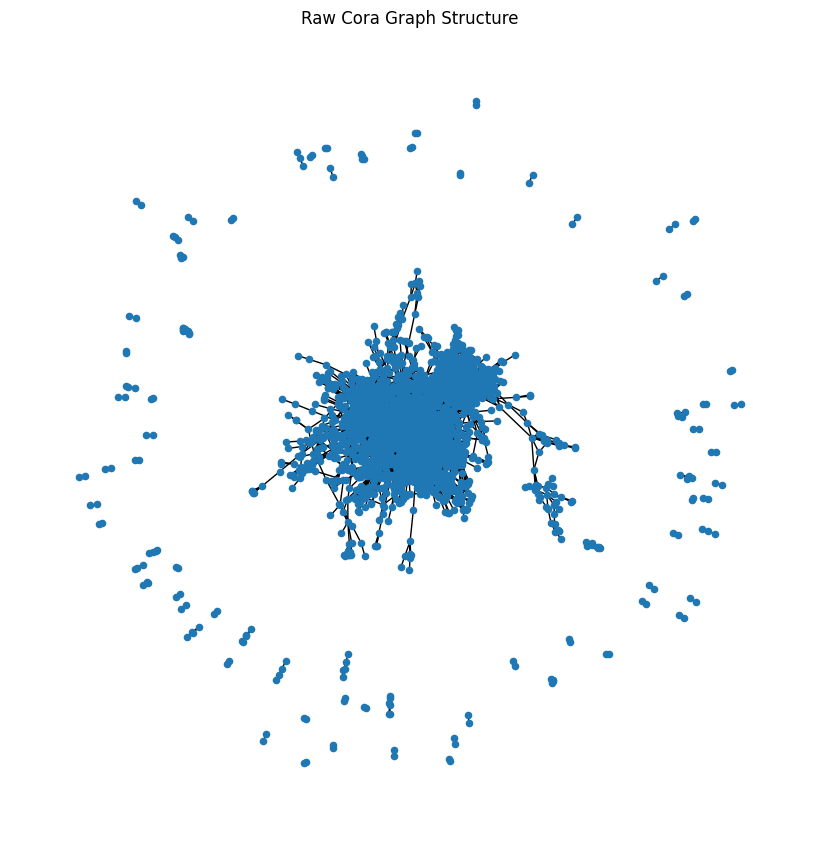

In [10]:
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(8, 8))
nx.draw(G, node_size=20, with_labels=False)
plt.title("Raw Cora Graph Structure")
plt.show()


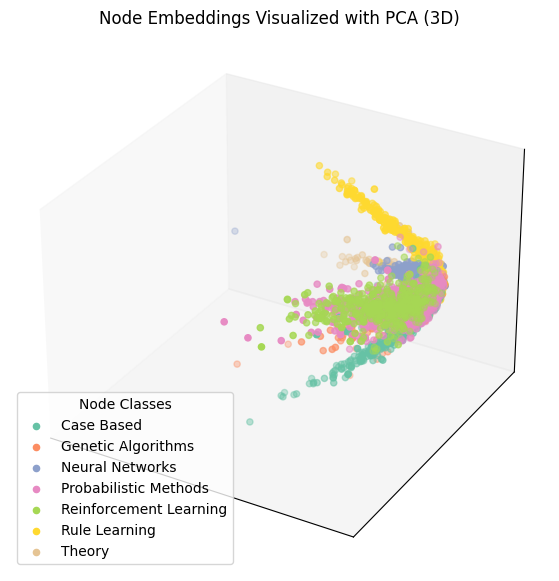

In [ ]:
model.eval()
with torch.no_grad():
    out = model(data)

z = out.cpu().numpy()
z_pca = PCA(n_components=3).fit_transform(z)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

classes = data.y.cpu().unique()
cmap = plt.get_cmap("Set2")
colors = [cmap(i) for i in range(len(classes))]

class_names = {
    0: "Case Based",
    1: "Genetic Algorithms",
    2: "Neural Networks",
    3: "Probabilistic Methods",
    4: "Reinforcement Learning",
    5: "Rule Learning",
    6: "Theory"
}

for i, cls in enumerate(classes):
    idx = (data.y.cpu() == cls).nonzero(as_tuple=True)[0]
    ax.scatter(z_pca[idx, 0], z_pca[idx, 1], z_pca[idx, 2], s=20, color=colors[i], label=class_names[i])

ax.set_title("Node Embeddings Visualized with PCA (3D)")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.legend(title="Node Classes", loc='lower left', fontsize=10)

plt.show()
